In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

## Load Files

In [99]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Experiment #'] = int(ix)

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, ix

def compose_experiment(wavelength, iteration):

	nv_filename = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-nv-' + str(iteration) + '.txt'
	b_filename  = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-b-' + str(iteration) + '.txt'

	nv_df, _ , _ , _  = read_filename(nv_filename)
	b_df , _ , _ , _ = read_filename(b_filename)	

	return nv_df, b_df
	

In [100]:
# read power to voltage data
df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)
df_pwr.head()

,535_V,535_mW,540_V,540_mW,545_V,545_mW,550_V,550_mW,555_V,555_mW,560_V,560_mW,565_V,565_mW,570_V,570_mW
0,0.149901,2.09,0.698322,3.89,0.253417,3.83,0.559756,3.87,0.362297,2.03,0.436171,2.49,0.289654,1.82,0.190533,1.90
1,0.606531,9.96,1.999350,11.44,1.033490,17.42,1.158700,8.23,2.283080,13.72,1.264840,7.60,2.261040,16.04,0.731263,8.76
2,1.311780,21.90,4.765400,27.50,1.926120,32.80,4.550870,33.00,4.105090,25.00,5.388710,33.00,4.683580,33.60,2.898430,36.50


In [101]:
def get_laser_pwr_fits_V_to_W():
	# read power to voltage data
	df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)

	# for each wavelength, store a linear regression
	regression_models = {}

	# make a list of available wavelengths
	wavelengths = [535+x*5 for x in range(8)]

	for w in wavelengths:

		# fit background PL(V) function, should be linear
		X = df_pwr[f'{w}_V'].to_numpy()
		y = df_pwr[f'{w}_mW'].to_numpy()

		# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
		X = X.reshape(-1, 1)

		# fit regression
		reg = LinearRegression().fit(X, y)

		# store fit
		regression_models[w] = reg

		# predict on unseen values (X_test)
		y_pred = reg.predict(X)

		# plot input values, and fit
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')
	
	return regression_models

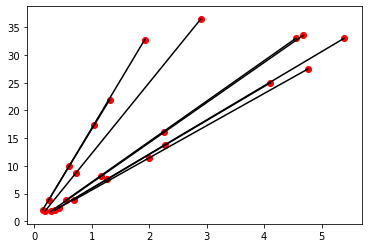

In [102]:
laser_pwr_V_to_W = get_laser_pwr_fits_V_to_W()

In [103]:
def get_params(filename):
	""" Retrieve parameters from a filename """

	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
		
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	return wavelength, location, ix

def read_filename(filename):
	""" Data preparation of a single experiment file """

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[1][17:]

	# pluck identifying information
	cc = id_string.split('-') # split into parts with - inbetween
	wavelength = cc[0]; # wavelength
	location = cc[1]; # background (b) or nv-center (nv)
	ix = cc[2].split('.')[0]; # experiment #

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Experiment #'] = ix

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, ix

def compose_experiment(wavelength, iteration):
    """ Gather background and NV data, and return pair """
    
    nv_filename = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-nv-' + str(iteration) + '.txt'
    b_filename  = 'PL_PC_records/PL and PC record-' + str(wavelength) + '-b-' + str(iteration) + '.txt'
    
    print (f"reading nv - {wavelength} - {iteration}")
    nv_df, _ , _ , _  = read_filename(nv_filename)
    
    print (f"reading b - {wavelength} - {iteration}")
    b_df , _ , _ , _ = read_filename(b_filename)	
    
    return nv_df, b_df

def get_laser_pwr_fits_V_to_W():
	""" This function reads an excel sheet with experimental data, and spits out 8 linear regressions  """
	# read power to voltage data
	df_pwr = pd.read_excel('laser power PDA (v) - powermeter (mW).xls', sheet_name="RAW", header=1)

	# for each wavelength, store a linear regression
	regression_models = {}

	# make a list of available wavelengths
	wavelengths = [535+x*5 for x in range(8)]

	for w in wavelengths:

		# fit background PL(V) function, should be linear
		X = df_pwr[f'{w}_V'].to_numpy()
		y = df_pwr[f'{w}_mW'].to_numpy()

		# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
		X = X.reshape(-1, 1)

		# fit regression
		reg = LinearRegression().fit(X, y)

		# store fit
		regression_models[w] = reg

		# predict on unseen values (X_test)
		y_pred = reg.predict(X)

		# plot input values, and fit
		plt.scatter(X, y,color='r') 
		plt.plot(X, y_pred,color='k')
	
	return regression_models

def get_saturation_curve(wavelength, iteration):

	# get nv-center and background data
	nv, b = compose_experiment(wavelength, iteration)

	# fit background PL(V) function, should be linear
	X = b['Laser Power (V)'].to_numpy()
	y = b['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# split dataset into 80% for training, 20% for testing
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

	# fit regression
	reg = LinearRegression().fit(X_train, y_train)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X_test)
	metric_mean_err = mean_absolute_error(y_test,y_pred)
	metric_max_err = max_error(y_test,y_pred)
	print("mean_absolute_error:", mean_absolute_error(y_test,y_pred), " - max_error:", max_error(y_test,y_pred))

	########## SUBTRACT BACKGROUND

	# conver the column into a readily base for regressing
	laser_power_nv = nv['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	nv['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	nv['PL_NV (#/s)'] = nv['PL (counts/s)'] - nv['PL_background']

	########## POWER - VOLTAGE to WATTAGE

	# conver the column into a vector for regression
	laser_power_nv_X = nv['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	nv['Laser Power (mW)'] = laser_pwr_V_to_W[int(wavelength)].predict(laser_power_nv_X)
	
	return nv, {'wavelength': int(wavelength), 'iteration': int(iteration), 'metric_mean_err':metric_mean_err, 'metric_mean_err':metric_max_err }



processing 540 - Experiment 3
reading nv - 540 - 3
reading b - 540 - 3
mean_absolute_error: 2125.18177016909  - max_error: 5466.759217591549
processing 550 - Experiment 3
reading nv - 550 - 3
reading b - 550 - 3
mean_absolute_error: 2305.8506700143043  - max_error: 6104.918009894958
processing 565 - Experiment 1
reading nv - 565 - 1
reading b - 565 - 1
mean_absolute_error: 4509.055393896723  - max_error: 9856.569731183467
processing 550 - Experiment 2
reading nv - 550 - 2
reading b - 550 - 2
mean_absolute_error: 2091.805063689067  - max_error: 5293.1121938216675
processing 540 - Experiment 2
reading nv - 540 - 2
reading b - 540 - 2
mean_absolute_error: 1000.3434840644404  - max_error: 3075.293432359118
processing 565 - Experiment 2
reading nv - 565 - 2
reading b - 565 - 2
mean_absolute_error: 2703.2349457073897  - max_error: 8374.047784891853
processing 565 - Experiment 3
reading nv - 565 - 3
reading b - 565 - 3
mean_absolute_error: 7233.8573280086275  - max_error: 26471.186878581764
p

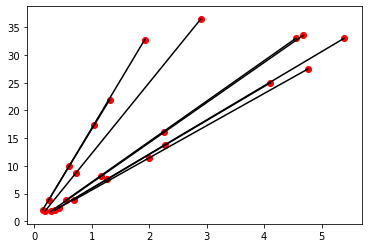

In [104]:
# get laser power regressions (V to W)
laser_pwr_V_to_W = get_laser_pwr_fits_V_to_W()

## Run Over All Files

all_saturation_curves = [] # will store all saturation curves
all_saturation_curves_on_wavelength = {} # dict: { wavelength: df_saturation curve }
experiments_done = {}

# determine a cood metric for a good experiment
metrics_df = pd.DataFrame()

# import required module
import os
# assign directory
directory = 'PL_PC_records'
FILE_PREFIX_CHECK = 'PL and PC record'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        # skip if this isn't out file
        prefx = f.split('/')[1][:16]
        if prefx != FILE_PREFIX_CHECK:
            continue

        # extract parameters
        wavelength, loc, exp_iter = get_params(f)
        
        # skip iteration, if we've processed this wavelength and experiment number
        if wavelength in experiments_done:
            if exp_iter in experiments_done[wavelength]:
                continue
                
        print (f"processing {wavelength} - Experiment {exp_iter}")

        # create saturation curve for this particullar wavelength, and exp_iter
        df, metrics = get_saturation_curve(wavelength, exp_iter)
        all_saturation_curves.append(df)
        
        metrics_df.append(metrics, ignore_index=True);

        # register that we've processed this experiment
        if wavelength not in experiments_done:
            experiments_done[wavelength] = []
            all_saturation_curves_on_wavelength[wavelength] = []
            
            # append dataframe
            all_saturation_curves_on_wavelength[wavelength].append(df)
            
            # append id, such that we won't process this dataframe upon coupled entries
            experiments_done[wavelength].append(exp_iter)
        else:
            
            # append dataframe
            all_saturation_curves_on_wavelength[wavelength].append(df)
            
            # append id, such that we won't process this dataframe upon coupled entries
            experiments_done[wavelength].append(exp_iter)
            
            

## k8 Fitting

In [195]:
km_old = 1.6E-6
kn_old = 50E-6

In [218]:
km = 5.3728E-6
kn = 66.756E-6

In [219]:
km / kn

0.08048415123734196

In [220]:
kn / km

12.424806432400239

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

k8 53.727919671201896 microPerSecond
k8 972604.4400400304 microPerSecond
k8 2322487.1631477266 microPerSecond
k8 53.727999999999994 microPerSecond
k8 2233592.379465485 microPerSecond


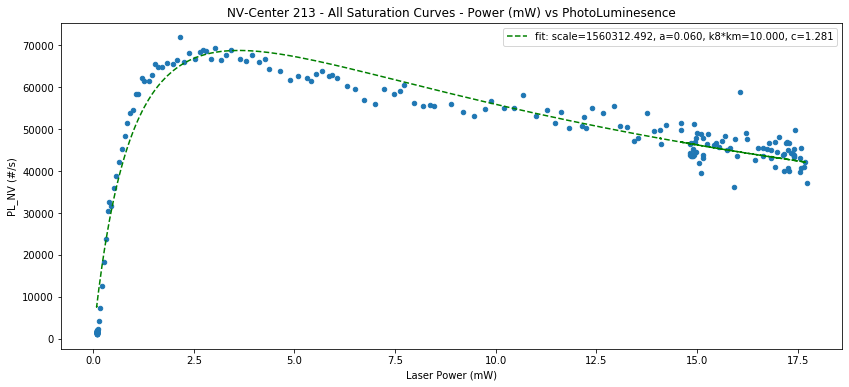

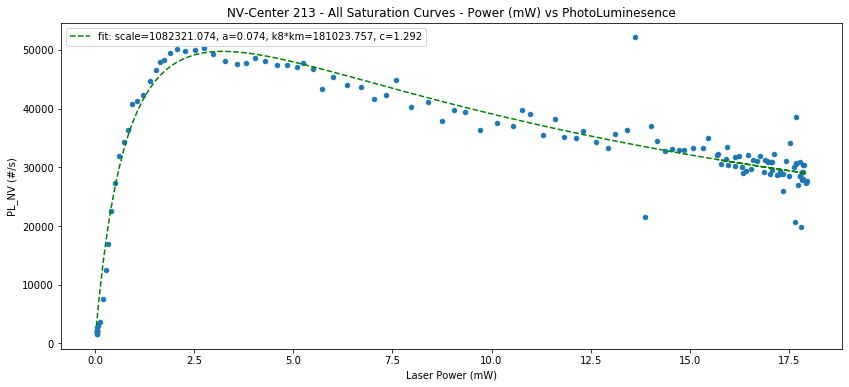

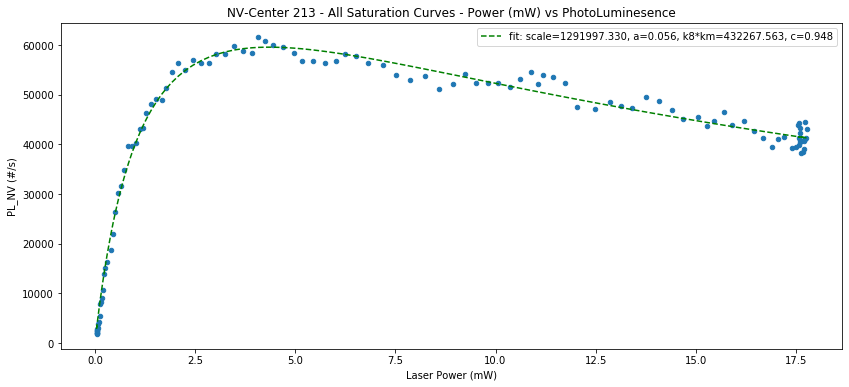

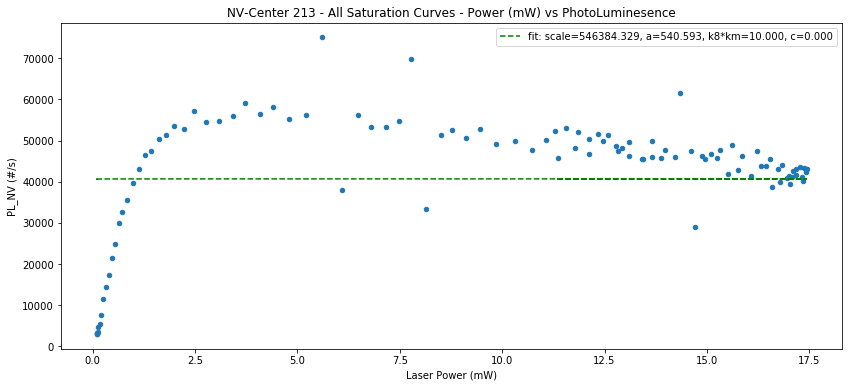

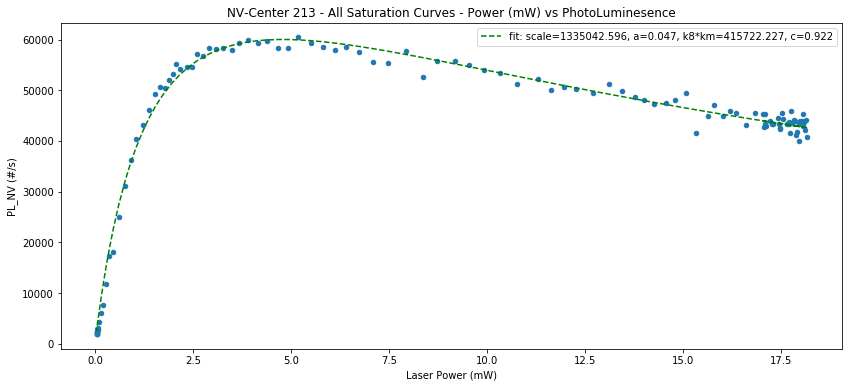

In [231]:
# km = 1.6E-6
# kn = 50E-6

def daria_fit(x, e, a, g, c):
	# d = km/kn  # <-- FIXED RATIO
	d = kn/km  # <-- Correct RATIO

	b=0
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

for df in all_saturation_curves_on_wavelength['535']:
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(daria_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	popt # contains fits for a-e

	print (f"k8 {popt[2] * km * 1E6} microPerSecond") # <-- HERE TOO, TIMES KN

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	label = 'fit: scale=%5.3f, a=%5.3f, k8*km=%5.3f, c=%5.3f' % tuple(popt)

	plt.plot(x, daria_fit(x, *popt), 'g--', label=label)

	plt.legend()

## Application to experiments

In [204]:
km = 1.6E-6
kn = 50E-6

def daria_fit(x, e, a, b, c):
	d = km/kn  # <-- FIXED RATIO
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

In [205]:
df_k8 = pd.DataFrame(columns=['wavelength', 'k8'])

for wavelength in all_saturation_curves_on_wavelength:
	for df in all_saturation_curves_on_wavelength[wavelength]:
	
		# data
		x = df['Laser Power (mW)'].to_numpy()
		y = df['PL_NV (#/s)'].to_numpy()

		# function fit
		popt, pcov = curve_fit(daria_fit, x, y,
			p0=[100000, 10, 10, 10],
			bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
			maxfev=100000
		)
		popt # contains fits for a-e

		df_k8 = df_k8.append({'wavelength': wavelength, 'k8': popt[2]}, ignore_index=True)

df_k8.wavelength = df_k8.wavelength.astype(float)

Text(0, 0.5, 'k8 in $\\mu s^{-1}$')

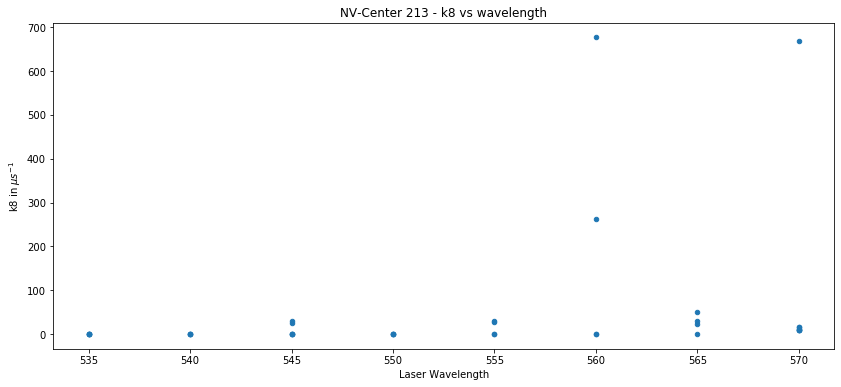

In [206]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_k8.plot.scatter(x='wavelength', y='k8', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - k8 vs wavelength")

ax1.set_xlabel('Laser Wavelength')
ax1.set_ylabel('k8 in $\mu s^{-1}$')

### Checking outlier at 560nm

Let's plot without outliers (560 and 570 seem to have big ones, and also analyse them further)

k8 over km 676.6393168338593
k8 over km 7.342039780302499e-18
k8 over km 262.16663835868803
k8 over km 1.4265234460063565e-17


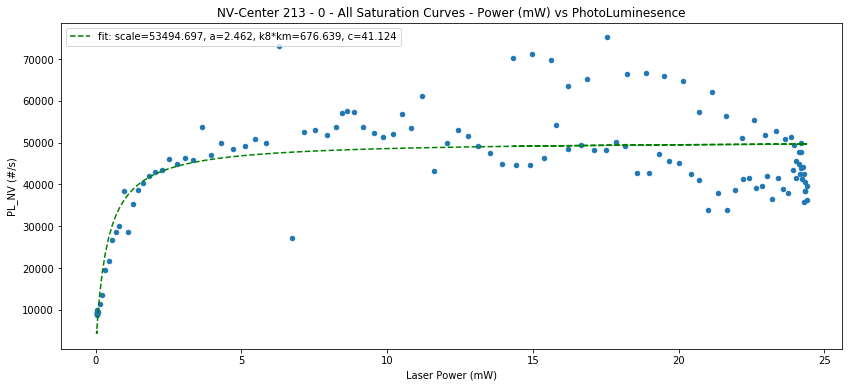

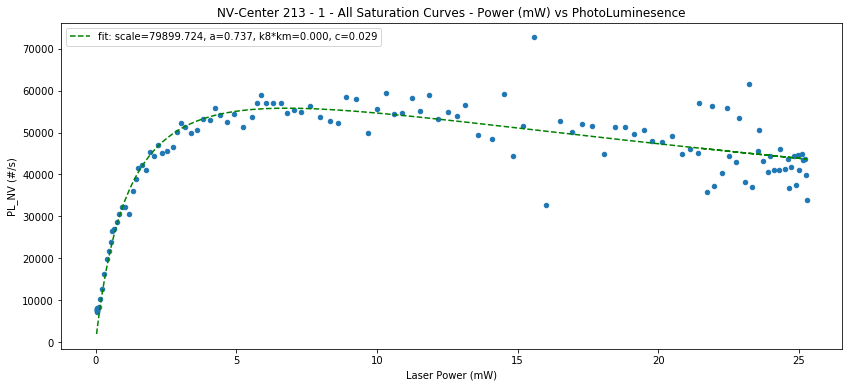

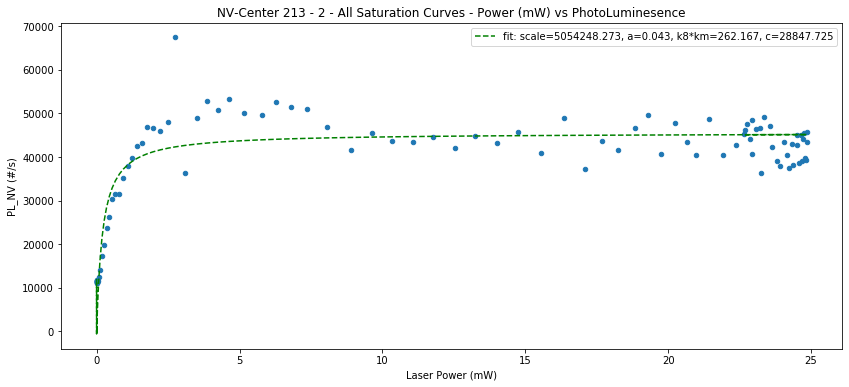

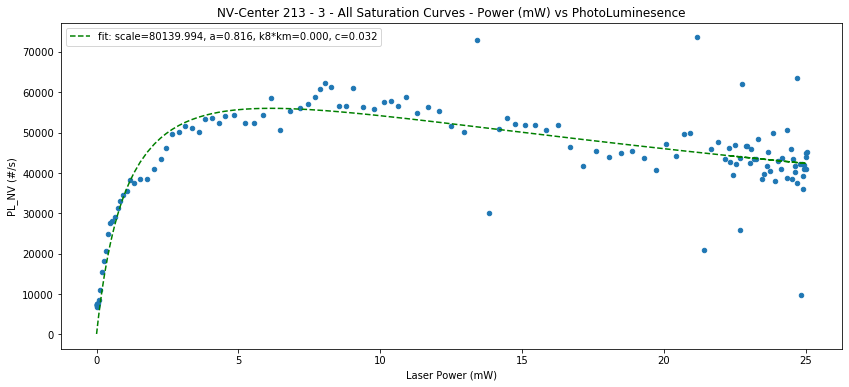

In [207]:
km = 1.6E-6
kn = 50E-6

def daria_fit(x, e, a, b, c):
	d = km/kn  # <-- FIXED RATIO
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

for ii, df in enumerate(all_saturation_curves_on_wavelength['560']):
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(daria_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	popt # contains fits for a-e

	print (f"k8 over km {popt[2]}") # <-- HERE TOO, TIMES KN

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - {ii} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	label = 'fit: scale=%5.3f, a=%5.3f, k8*km=%5.3f, c=%5.3f' % tuple(popt)

	plt.plot(x, daria_fit(x, *popt), 'g--', label=label)

	plt.legend()

We can confirm that 0 and 2 aren't a good fit, hence the explotion os the k8 coefficient, unless there's more hidden information there

### Checking outlier at 570nm

k8 over km 667.9316974680846
k8 over km 10.77743991479599
k8 over km 14.919111867109603
k8 over km 9.796589989557983
k8 over km 16.52921463523292
k8 over km 9.630366238906825
k8 over km 9.22078534879771
k8 over km 10.111070247079272


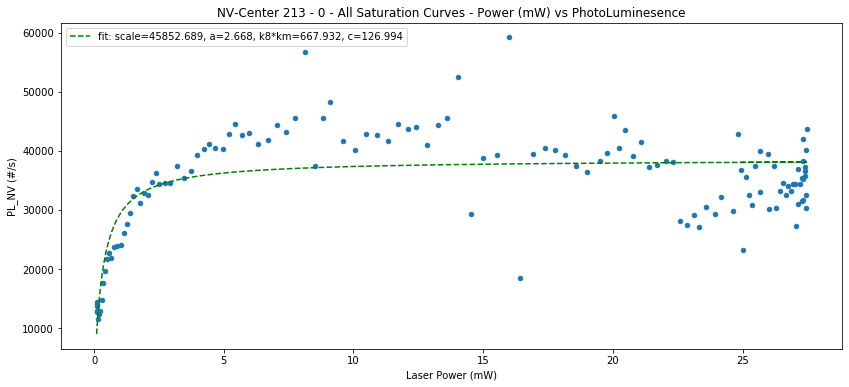

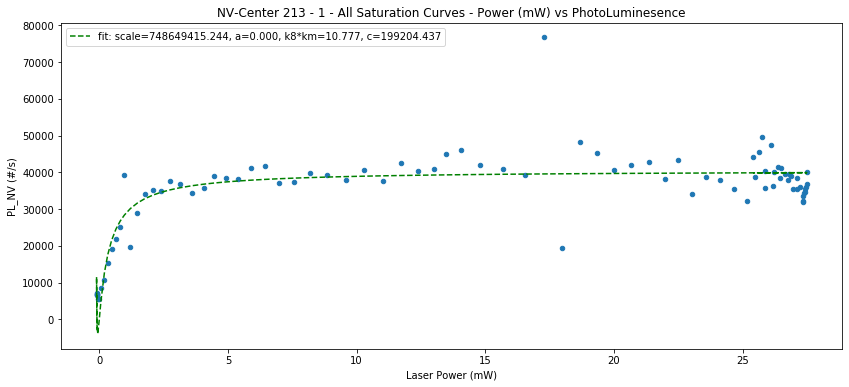

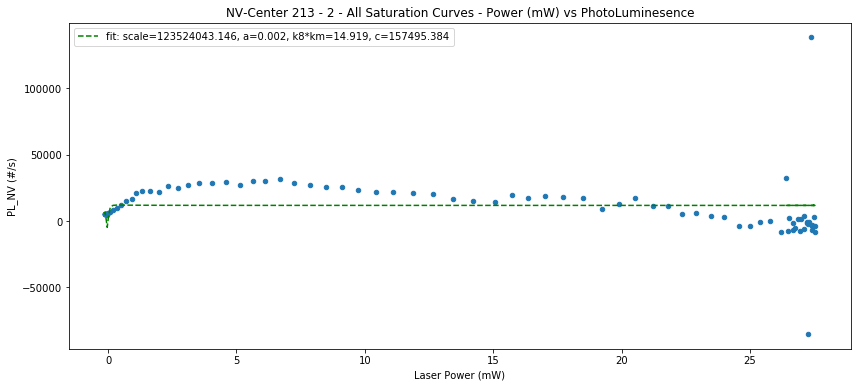

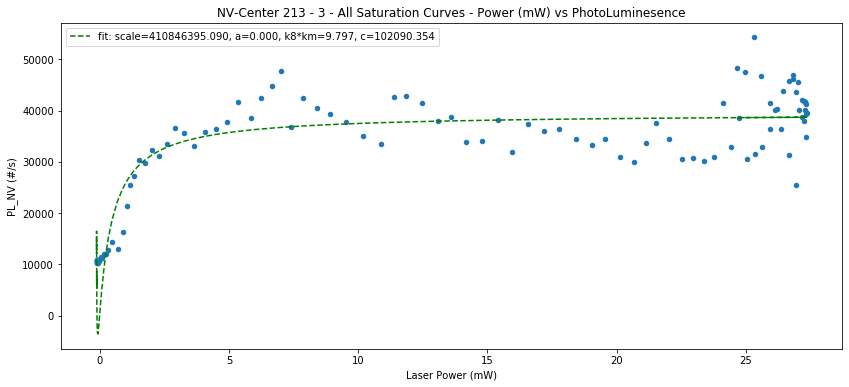

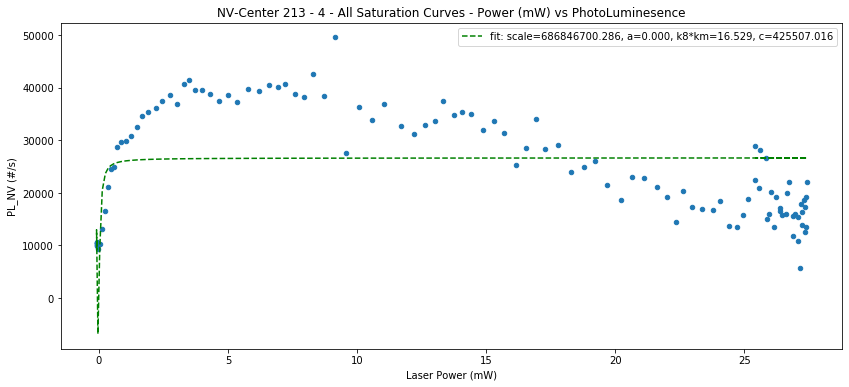

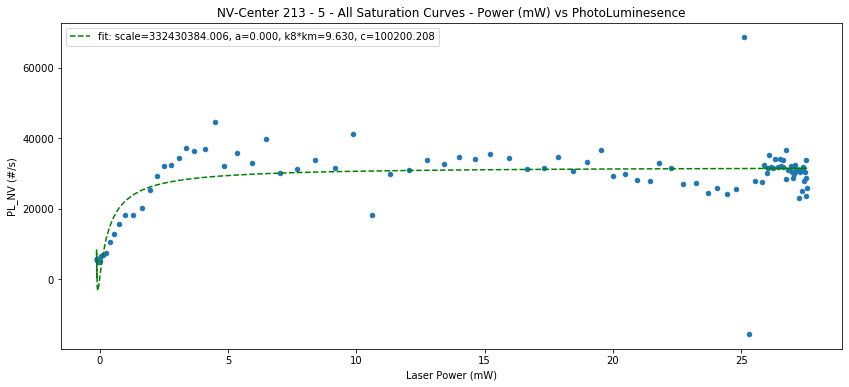

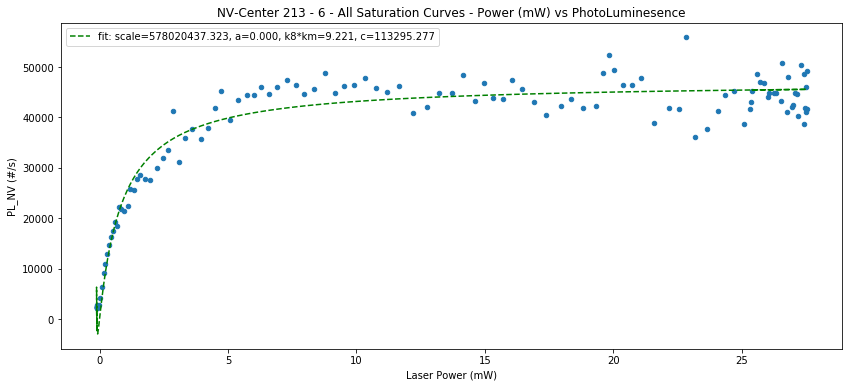

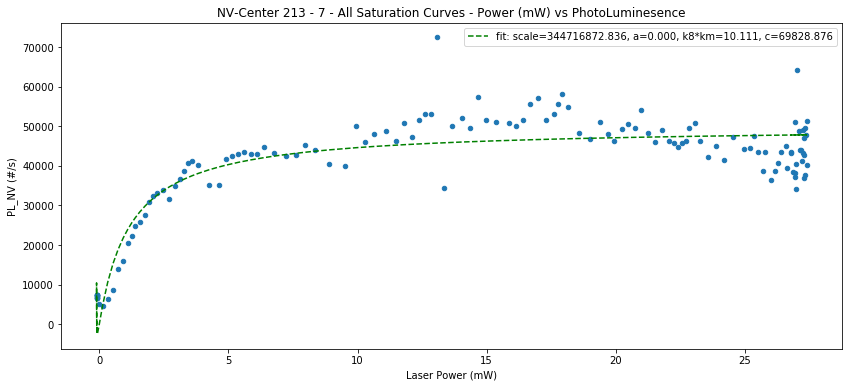

In [112]:
km = 1.6E-6
kn = 50E-6

def daria_fit(x, e, a, b, c):
	d = km/kn  # <-- FIXED RATIO
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

for ii, df in enumerate(all_saturation_curves_on_wavelength['570']):
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(daria_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	popt # contains fits for a-e

	print (f"k8 over km {popt[2]}") # <-- HERE TOO, TIMES KN

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - {ii} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	label = 'fit: scale=%5.3f, a=%5.3f, k8*km=%5.3f, c=%5.3f' % tuple(popt)

	plt.plot(x, daria_fit(x, *popt), 'g--', label=label)

	plt.legend()

Zero is a terrible fit. For the others, the k9*km value seems to be pretty stable, so we're going to keep the others.

In conclusion, it's safe to ignore the presented outliers

## k8 calculation and plotting Without outliers

Text(0, 0.5, 'k8 in $\\mu s^{-1}$')

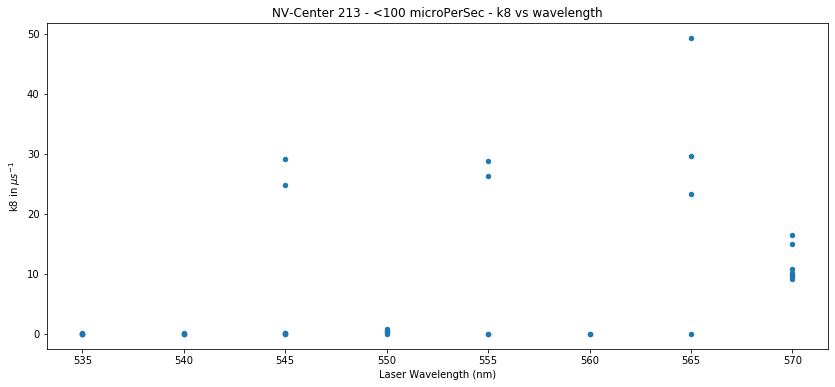

In [208]:
df_k8_bias = df_k8.loc[df_k8.k8<100, :]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_k8_bias.plot.scatter(x='wavelength', y='k8', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - <100 microPerSec - k8 vs wavelength")

ax1.set_xlabel('Laser Wavelength (nm)')
ax1.set_ylabel('k8 in $\mu s^{-1}$')

Text(0, 0.5, 'k8 in $\\mu s^{-1}$')

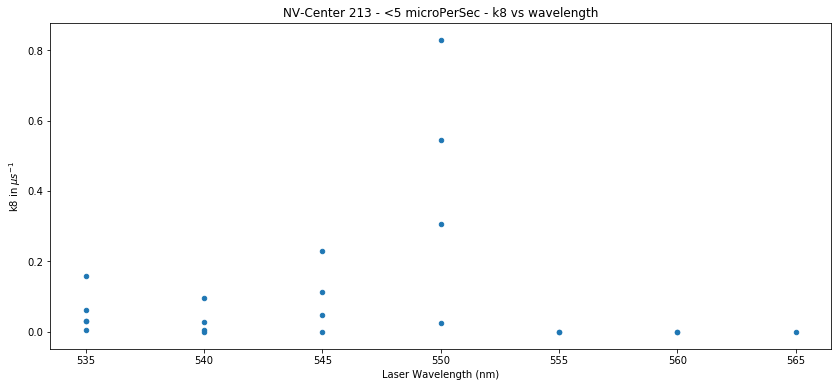

In [209]:
df_k8_bias_2 = df_k8.loc[df_k8.k8<5, :]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
df_k8_bias_2.plot.scatter(x='wavelength', y='k8', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - <5 microPerSec - k8 vs wavelength")

ax1.set_xlabel('Laser Wavelength (nm)')
ax1.set_ylabel('k8 in $\mu s^{-1}$')

## Boxplotting the averages

In [210]:
bp['k8']['medians'][0].get_ydata()[0]

0.031223592758778593

In [211]:
m1

8.180096999952175

In [212]:
from matplotlib.cbook import boxplot_stats

In [213]:
bp['k8']['means']

/Users/blvck/miniconda3/envs/drlnd/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


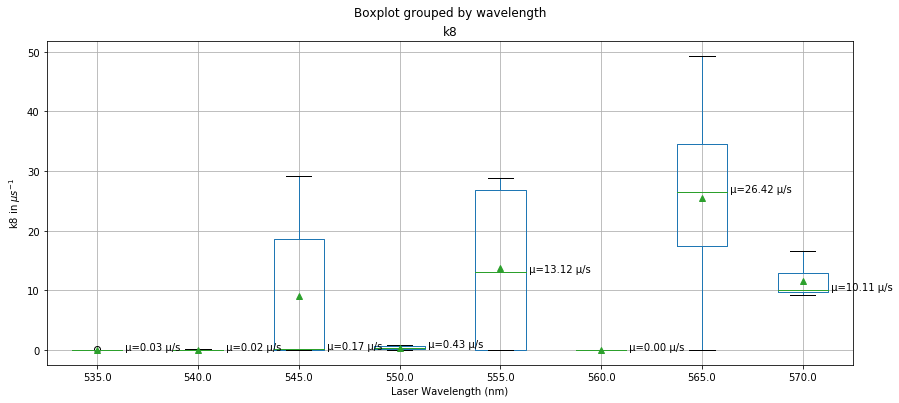

In [214]:
df_k8_bias_2 = df_k8.loc[df_k8.k8<100, :]

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
bp = df_k8_bias_2.boxplot(by='wavelength', column='k8', ax=ax1, showmeans=True, return_type='dict', grid=True)

ax1.set_xlabel('Laser Wavelength (nm)')
ax1.set_ylabel('k8 in $\mu s^{-1}$')

for i, line in enumerate(bp['k8']['medians']):
    x, y = line.get_xydata()[1]

    mean = (bp['k8']['medians'][i]).get_ydata()[1]

    text = ' μ={:.2f} μ/s'.format(mean)
    ax1.annotate(text, xy=(x, y))

In [215]:
k8_means = df_k8_bias_2.groupby('wavelength').agg({'k8':['mean', 'std']})
k8_means

k8              
                    mean           std
wavelength                            
535.0       5.736046e-02  5.906032e-02
540.0       3.220926e-02  4.460842e-02
545.0       9.032899e+00  1.391196e+01
550.0       4.262710e-01  3.427795e-01
555.0       1.374769e+01  1.590730e+01
560.0       1.080364e-17  4.895438e-18
565.0       2.554751e+01  2.032957e+01
570.0       1.156923e+01  2.915275e+00

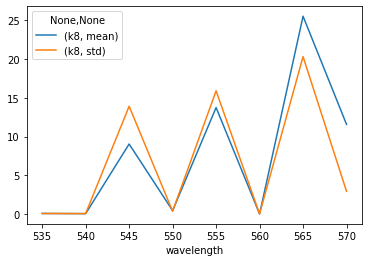

In [216]:
k8_means.plot()

In [130]:
k8_means_b

wavelength            k8              
                      mean           std
0      535.0  5.736046e-02  5.906032e-02
1      540.0  3.220926e-02  4.460842e-02
2      545.0  9.709548e-02  9.874327e-02
3      550.0  4.262710e-01  3.427795e-01
4      555.0  8.919160e-17  1.258455e-16
5      560.0  1.080364e-17  4.895438e-18
6      565.0  3.871327e-16           NaN

Text(0, 0.5, 'k8 in $\\mu s^{-1}$')

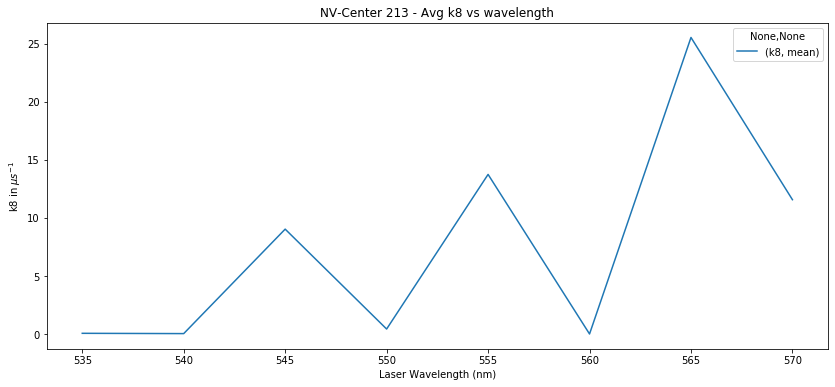

In [217]:
k8_means_b = k8_means.reset_index()

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
k8_means_b.plot.line(x='wavelength', y=('k8', 'mean'), ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Avg k8 vs wavelength")

ax1.set_xlabel('Laser Wavelength (nm)')
ax1.set_ylabel('k8 in $\mu s^{-1}$')

Is it absolutely normal that k8 changes with wavelength?! If this is true, then k8 is actually a system of something else... we're clearly measuring more than k8 when fitting the curve!

k8 over km 0.5451274751235626
k8 over km 0.3056479430353173
k8 over km 0.8295315643418937
k8 over km 0.024777043101804664


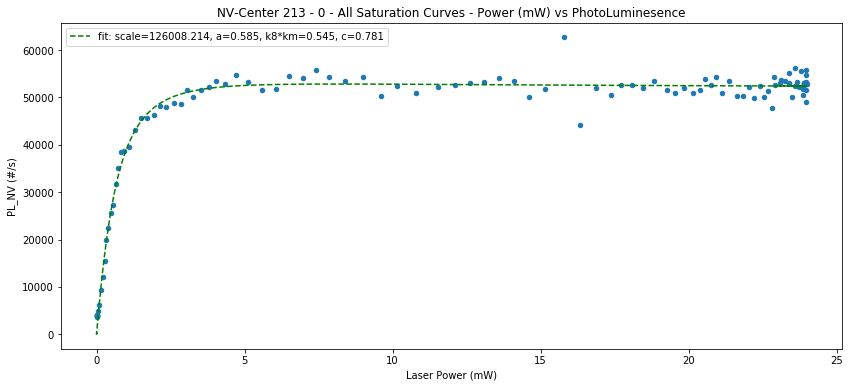

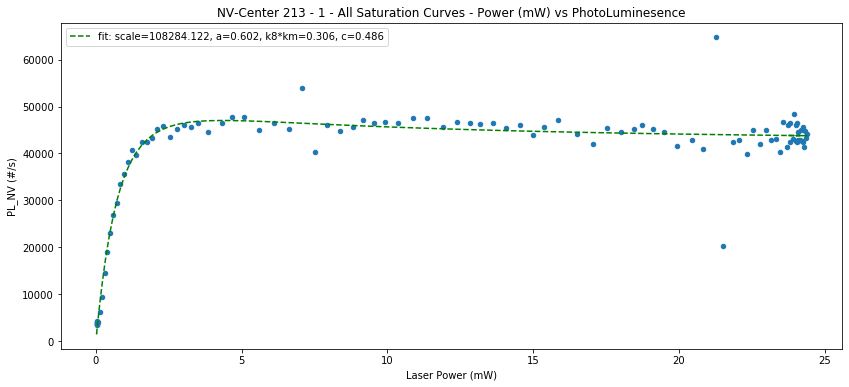

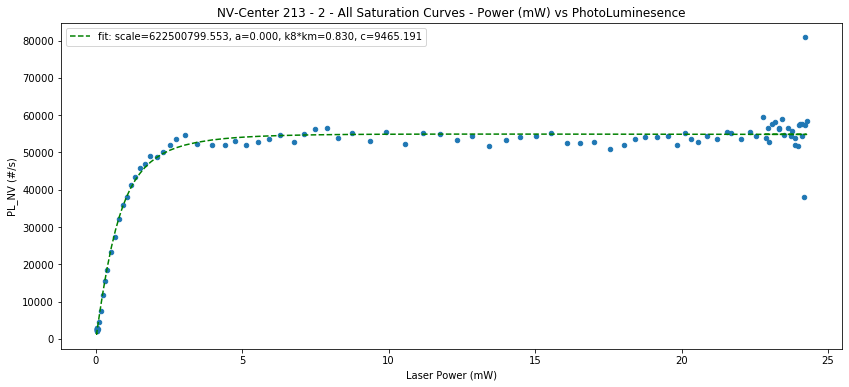

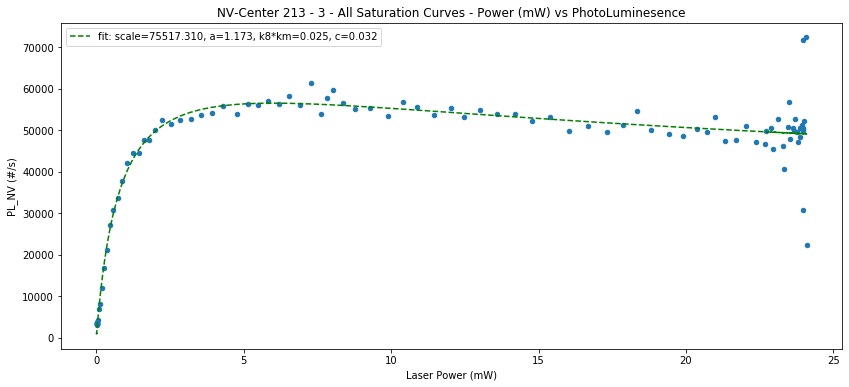

In [125]:
km = 1.6E-6
kn = 50E-6

def daria_fit(x, e, a, b, c):
	d = km/kn  # <-- FIXED RATIO
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

for ii, df in enumerate(all_saturation_curves_on_wavelength['550']):
	
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_NV (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(daria_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	popt # contains fits for a-e

	print (f"k8 over km {popt[2]}") # <-- HERE TOO, TIMES KN

	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_NV (#/s)', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - {ii} - All Saturation Curves - Power (mW) vs PhotoLuminesence")

	label = 'fit: scale=%5.3f, a=%5.3f, k8*km=%5.3f, c=%5.3f' % tuple(popt)

	plt.plot(x, daria_fit(x, *popt), 'g--', label=label)

	plt.legend()